In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ["CUDA_VISIBLE_DEVICES"] = '3' 

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

In [2]:
# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [3]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
best_exp = rs.get_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    metric="val-dice_score",
    checkpoint="max-val-dice_score",
    device="cuda"
)

/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


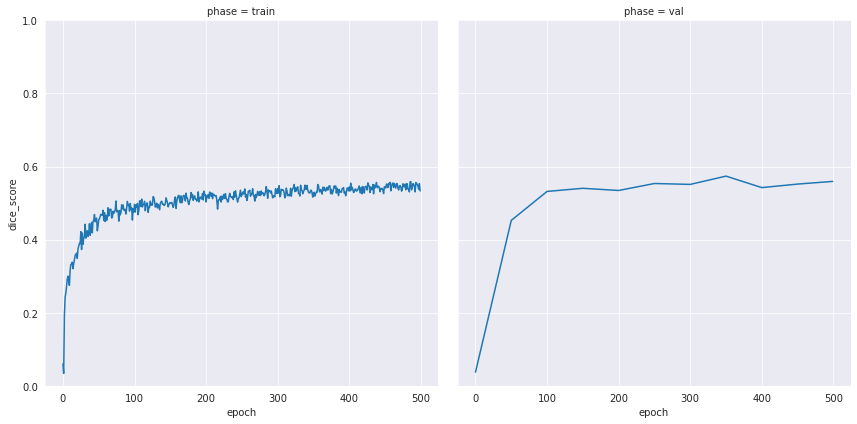

In [5]:
best_exp.vis_loss_curves(height=6)

In [6]:
%%yaml dataset_cfg 

_class: ese.experiment.datasets.WMH
annotator: observer_o12
axis: 0
split: val 
num_slices: 1
slicing: midslice 
task: Amsterdam 
version: 0.2

<IPython.core.display.Javascript object>

In [7]:
from ionpy.experiment.util import absolute_import
from torch.utils.data import DataLoader

dataset_cls = absolute_import(dataset_cfg.pop("_class"))
WMH_Dataset = dataset_cls(**dataset_cfg)
wmh_dataloader = DataLoader(WMH_Dataset, batch_size=1, shuffle=False, drop_last=False)

In [8]:
from ionpy.util.torchutils import to_device
import torch
import numpy as np
from tqdm.notebook import tqdm
from ionpy.metrics import dice_score
import einops

def get_dataset_perf(
        exp, 
        dataloader, 
        background_threshold=0.0001
        ):

    items = []
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            # Get your image label pair and define some regions.
            x, y = to_device(batch, exp.device)
            
            # Reshape to a good size
            x = einops.rearrange(x, "b c h w -> (b c) 1 h w")
            y = einops.rearrange(y, "b c h w -> (b c) 1 h w")
                             
            yhat = exp.model(x)  
            fore_regions = (y==1)
            back_regions = (y==0)
            
            # Extract predictions
            soft_foreground_pred = torch.sigmoid(yhat)
            # If you want to eliminate background pixels, do so
            if background_threshold > 0:
                soft_foreground_pred[soft_foreground_pred < background_threshold] = 0

            soft_background_pred = 1 - soft_foreground_pred 

            hard_foreground_pred = (soft_foreground_pred > 0.5).float()
            hard_background_pred = 1 - hard_foreground_pred

            # Compute metrics
            dice_met = np.round(dice_score(yhat, y).cpu().numpy(), 3)
            loss_image = (y - soft_foreground_pred) # Not really all that meaningful, just looking at per-pixel differences (can be thought of as soft accuracy).

            ## Calculate calibration image.

            # The calibration image is define as PER-PIXEL the difference between (accu(P) - conf(P)).
            calibration_image = torch.zeros_like(loss_image)
            foreground_accuracy = (y == hard_foreground_pred).float()
            background_accuracy = ((1 - y) == hard_background_pred).float()

            # Set the regions of the image corresponding to groundtruth label.
            calibration_image[fore_regions] = (foreground_accuracy - soft_foreground_pred).abs()[fore_regions]
            calibration_image[back_regions] = (background_accuracy - soft_background_pred).abs()[back_regions]
            
            ## Finally, we want to calculate two tensors (one for each class) that consists of two channels:
            # 1. The match of the prediction
            # 2. The confidence of the prediction
            pix_info = {
                "foreground": torch.stack([foreground_accuracy, soft_foreground_pred], dim=0).view(2, -1).cpu().numpy(),
                "background": torch.stack([background_accuracy, soft_background_pred], dim=0).view(2, -1).cpu().numpy()
            }

            # Wrap it in an item
            items.append({
                "image": x.cpu().squeeze(),
                "label": y.cpu().squeeze(),
                "soft_pred": soft_foreground_pred.cpu().squeeze(),
                "hard_pred": hard_foreground_pred.cpu().squeeze(),
                "dice_score": dice_met,
                "loss": loss_image.cpu().squeeze(),
                "calibration err": calibration_image.cpu().squeeze(),
                "pix_info": pix_info
            })

    return items

In [9]:
# val_perf is a dict where each item is the subj id
# with the y, ypred, yloss, ydice
predictions_dict = get_dataset_perf(
    exp=best_exp, 
    dataloader=wmh_dataloader
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
import matplotlib.pyplot as plt

def visualize_predictions(perf_dict):
    # We are going to visualize 5 things here
    # - The image
    # - The ground truth
    # - The hard prediction (with loss above it)
    # - The delta between the ground truth and the soft prediction
    # - The Calibration error (Acc - Soft Pred)

    color_dict = {
        "loss": "twilight",
        "calibration err": "plasma",
    }

    skip_keys = ["pix_info"]

    for subj in perf_dict:

        # Create the subplots for this subject
        num_keys = len(subj.keys()) - len(skip_keys)
        f, axarr = plt.subplots(1, num_keys, figsize=(5 * num_keys, 5))

        for k_idx, key in enumerate(subj.keys()):
            if key not in skip_keys:
                if key in color_dict:
                    im = axarr[k_idx].imshow(subj[key], cmap=color_dict[key])
                else:
                    im = axarr[k_idx].imshow(subj[key], cmap="gray")
                axarr[k_idx].axis("off")
                axarr[k_idx].set_title(key)
                f.colorbar(im, ax=axarr[k_idx])

        plt.show()

# 1. Let's look at how the ECE looks like if we evaluate over subjects, and what the distribution looks like.

In [11]:
from ese.experiment.metrics import ECE

ece_foreground_scores = [ECE(bins=torch.from_numpy(np.linspace(0.5, 1, 10)[:-1]),
                             confidences=torch.from_numpy(subj["pix_info"]["foreground"][1]), 
                             accuracies=torch.from_numpy(subj["pix_info"]["foreground"][0]), 
                             reduce="mean") for subj in predictions_dict]

In [12]:
np.mean(ece_foreground_scores)

0.2709839512904485

<Axes: ylabel='Count'>

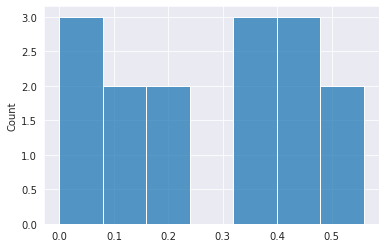

In [13]:
sns.histplot(ece_foreground_scores, bins=7)

# 2. Expected Semantic Error (ESE) 

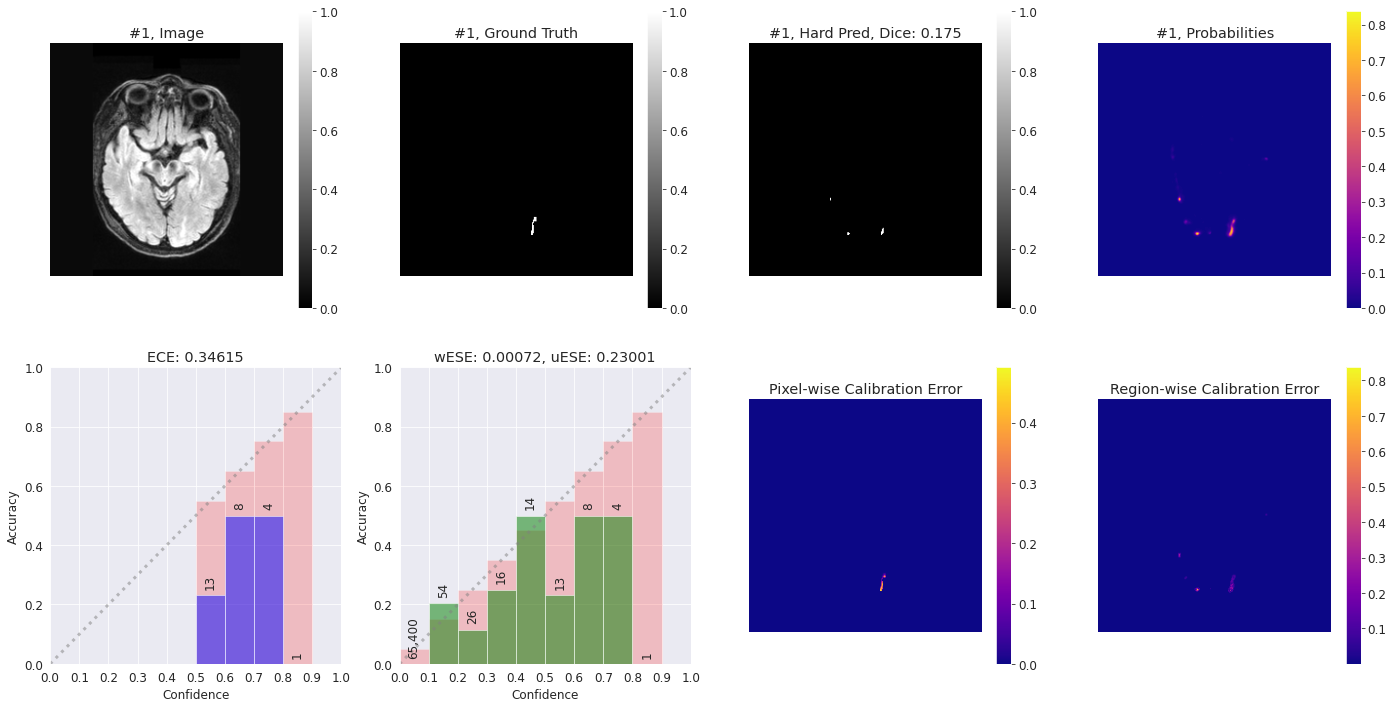

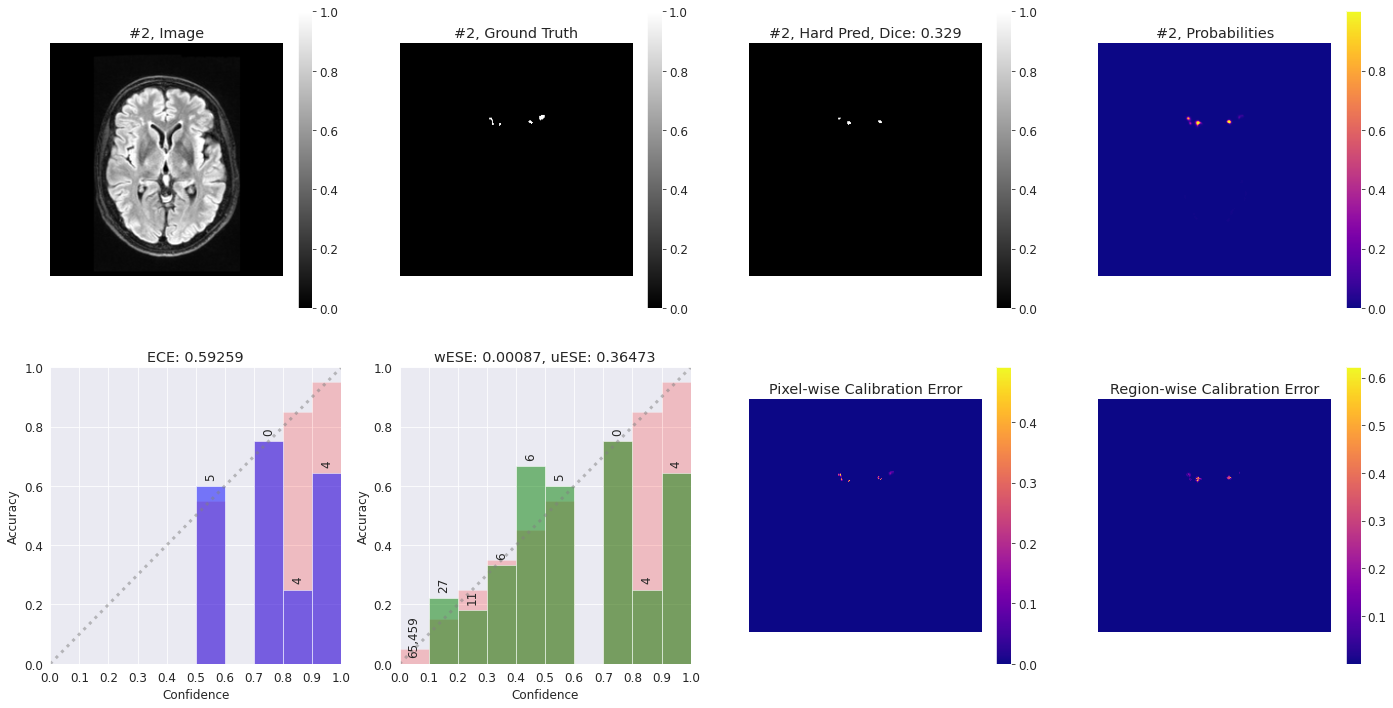

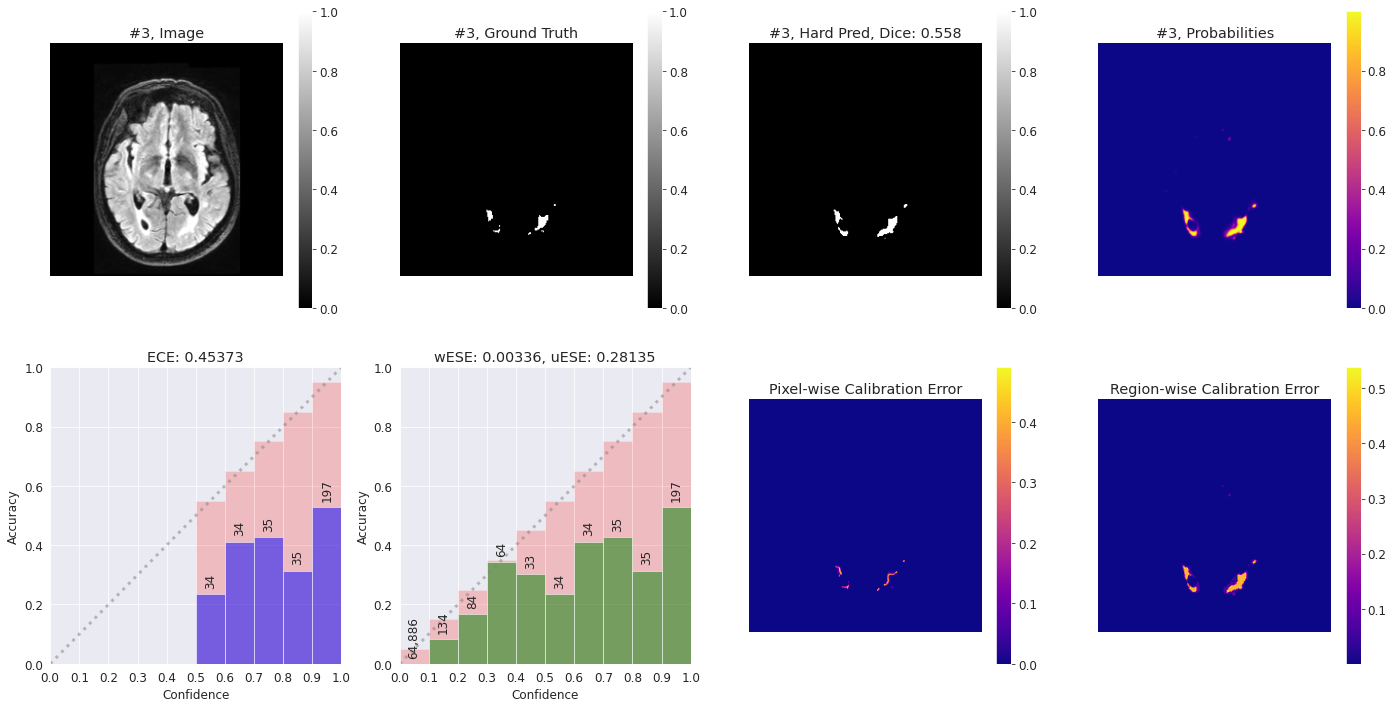

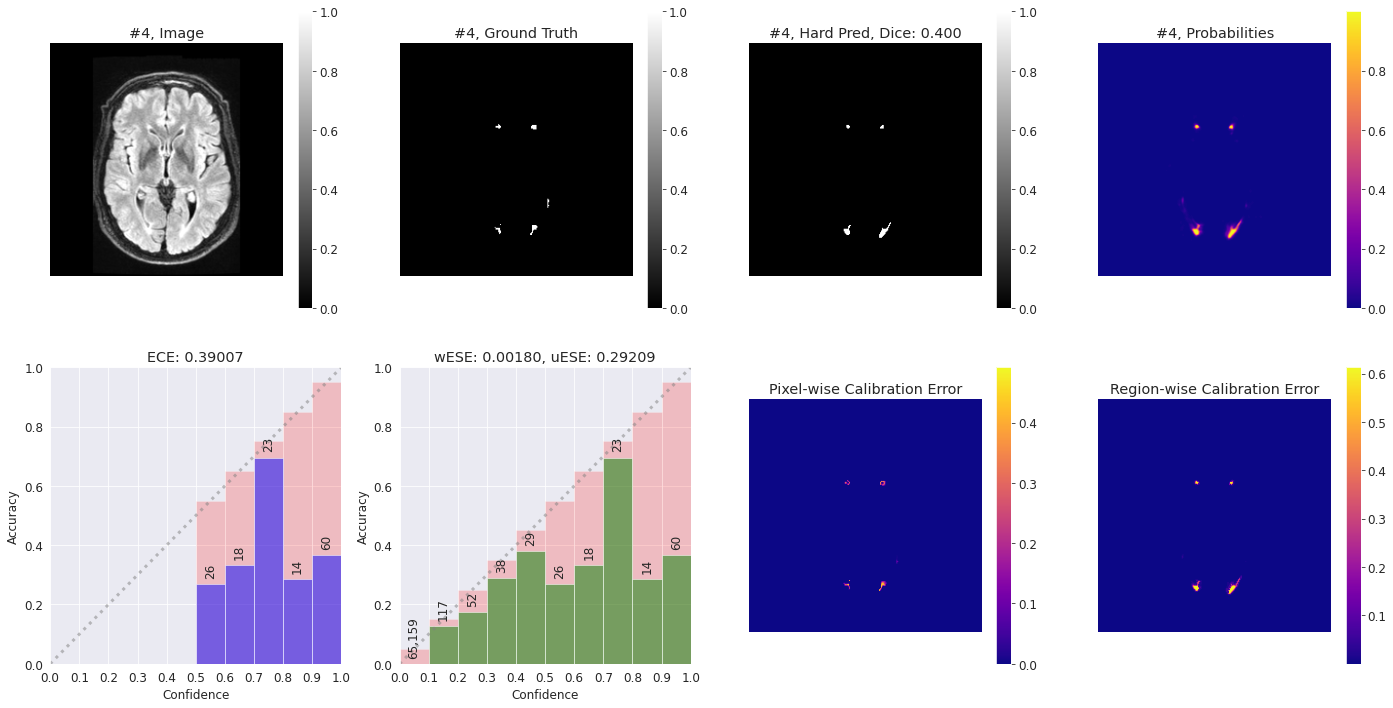

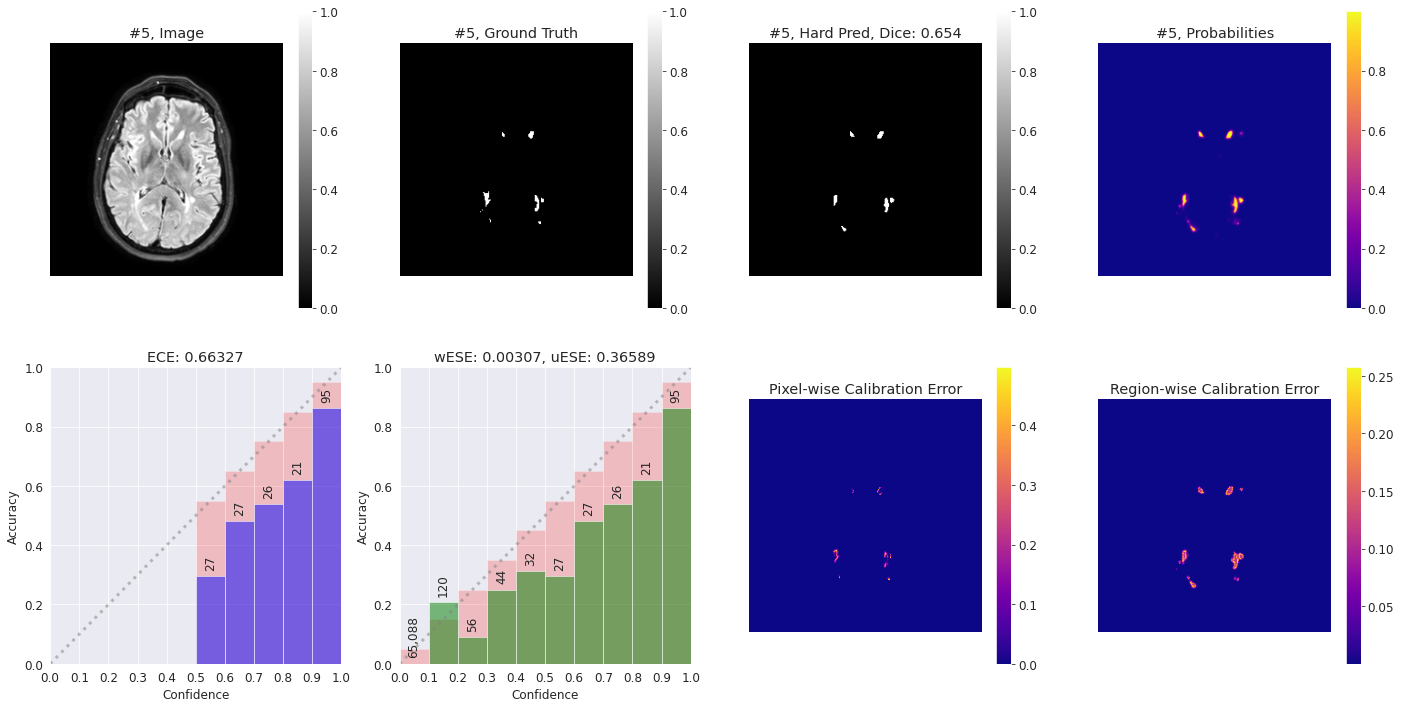

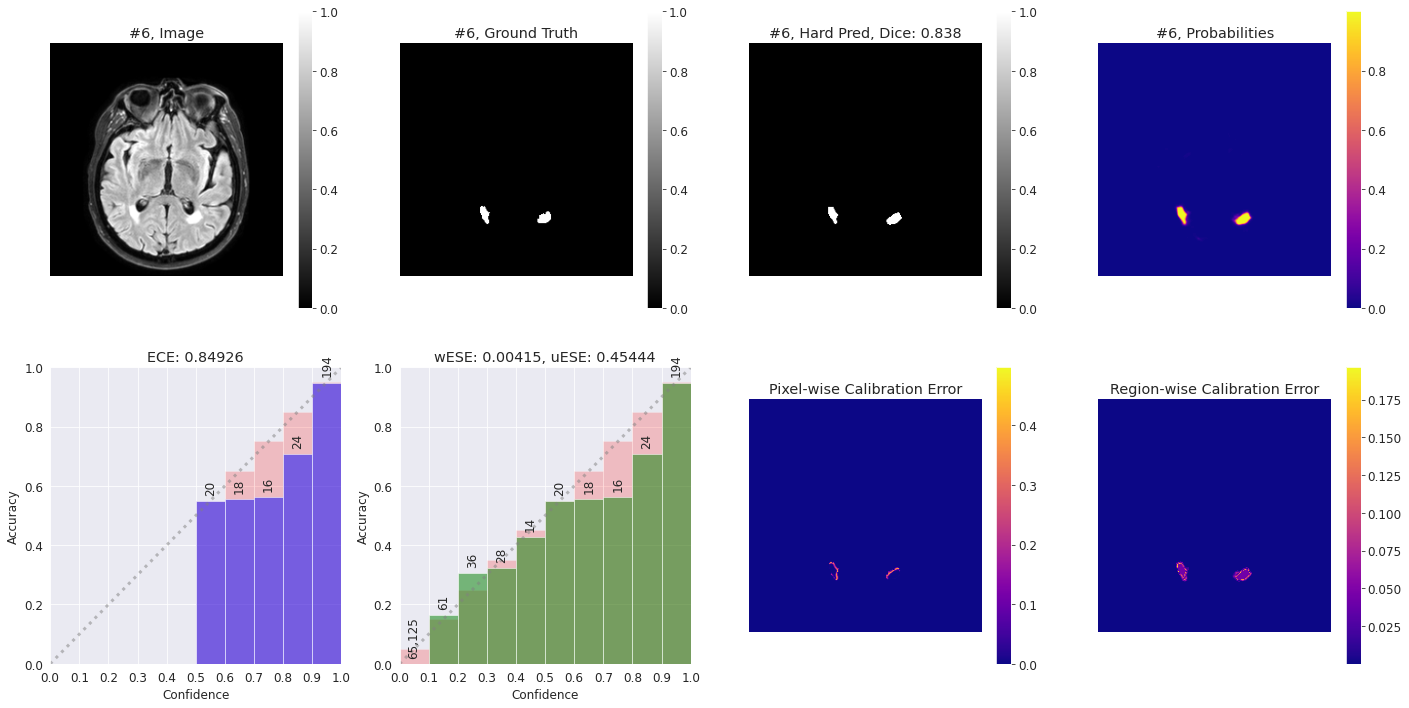

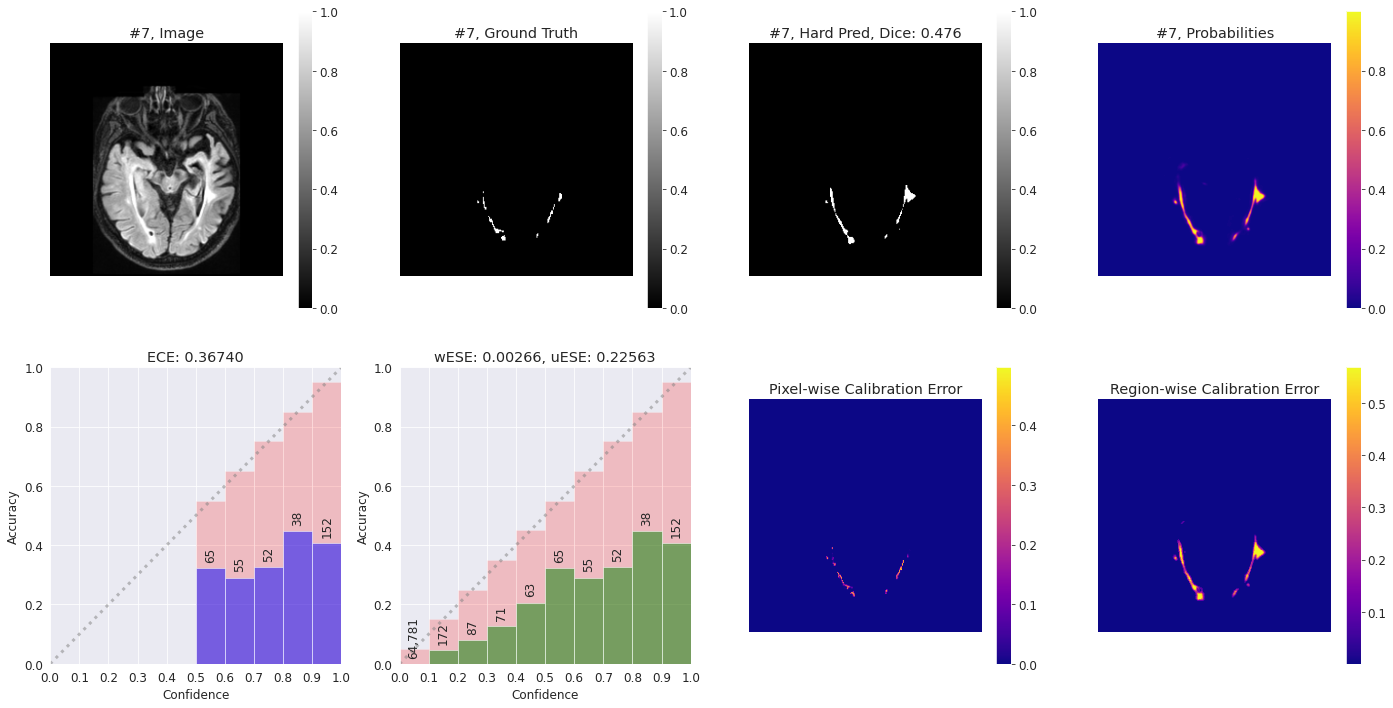

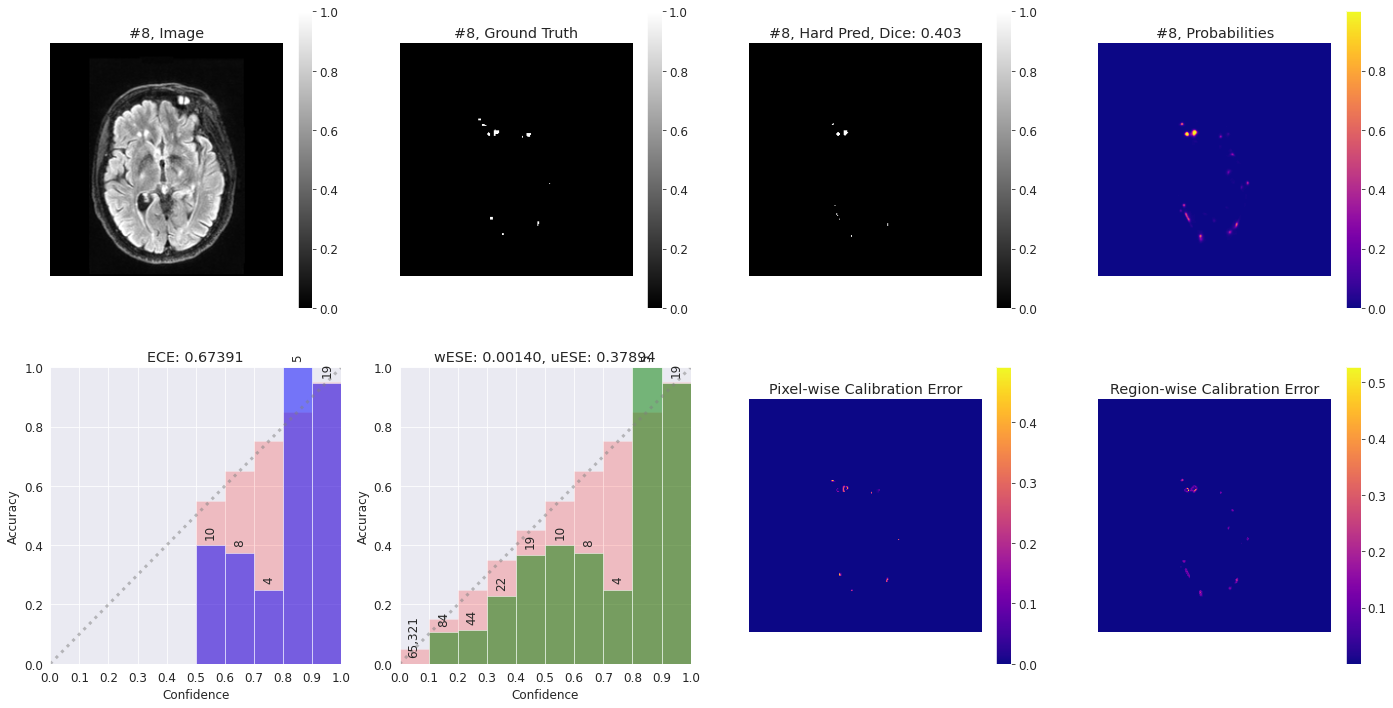

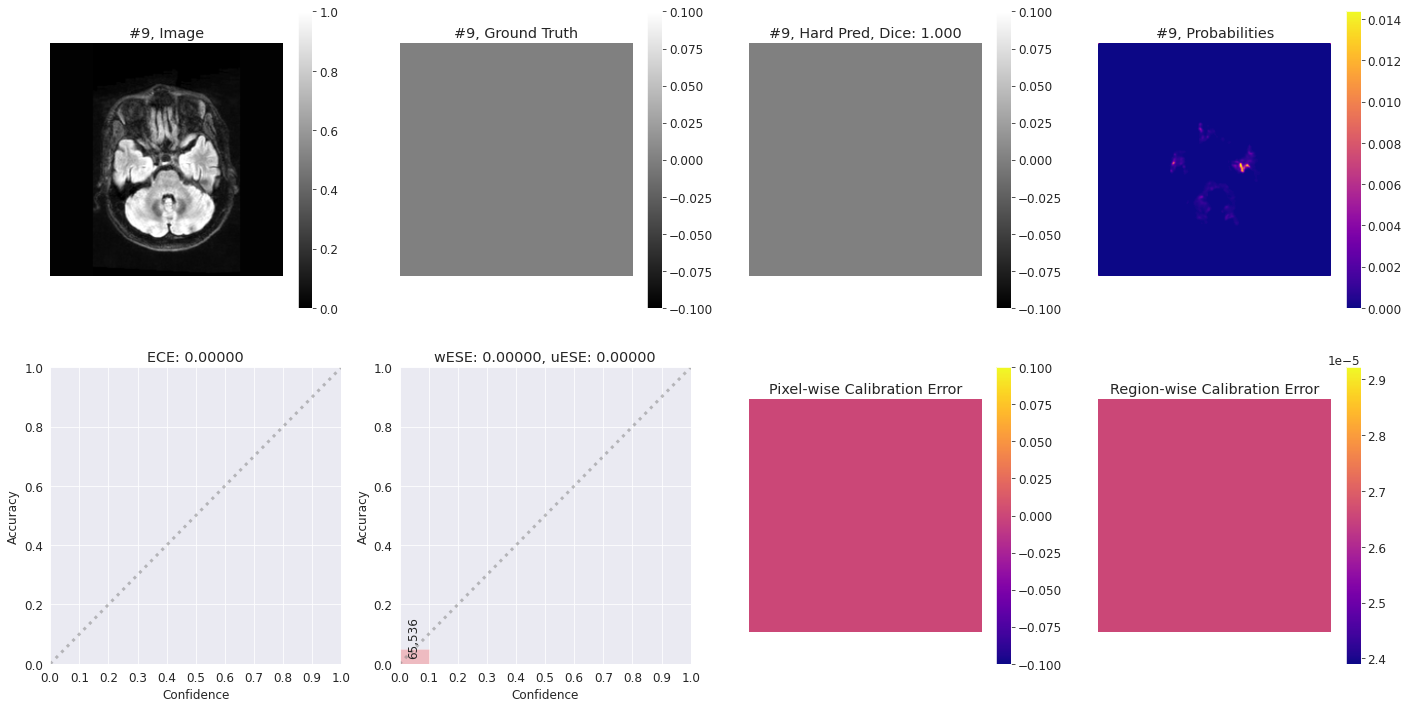

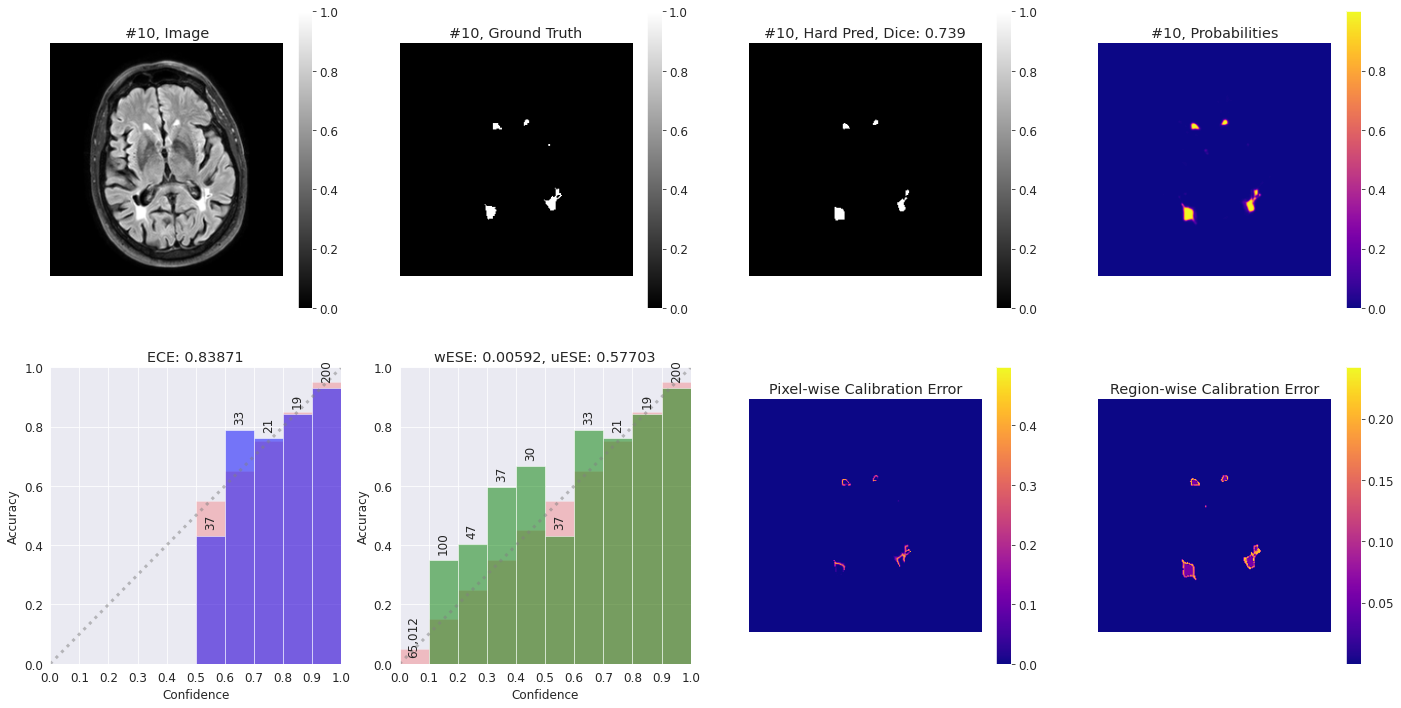

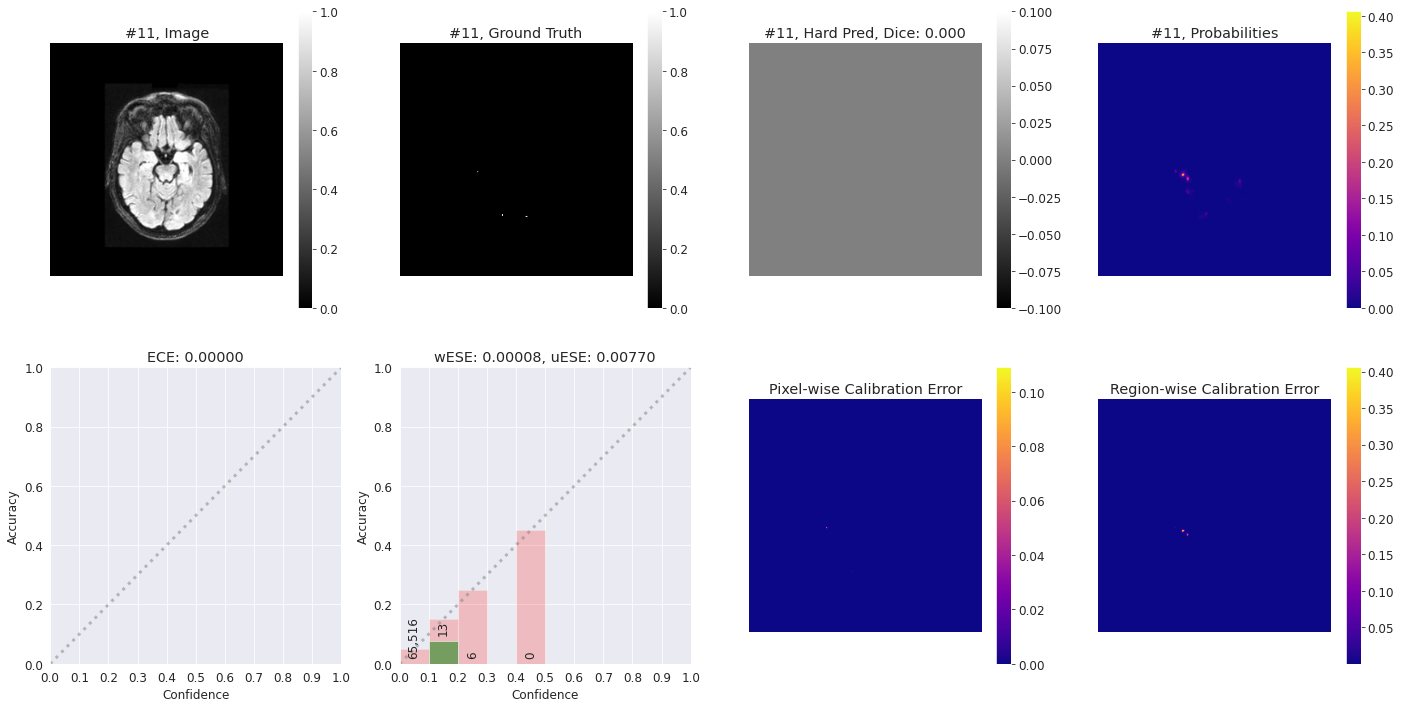

In [14]:
from ese.experiment.analysis.diagrams import subject_plot

subject_plot(
    subject_dict=predictions_dict,
    num_bins=10,
    show_bin_amounts=True
)

In [ ]:
from ese.experiment.analysis.diagrams import aggregate_plot

aggregate_plot(
    subject_dict=predictions_dict,
    num_bins=10
)